This is a Jupyter notebook for trajectory analysis of a Hexaglide manipulator

## 1. Code for inverse kinematics (IK) and forward kinematics (FK) calculation according to Palpacelli et al. (2020)

Imports

In [1]:
from utils import *
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R
from sklearn import preprocessing
from planner import *
import math as m

IK solver

In [2]:
class IKSolver:
    def __init__(self):
        self.init_rotation_matrix = np.eye(3, 3, dtype=float)
        self.init_translation_vector = np.array([0.0, 0.0, 278.256])
        self.init_translation_vector = self.init_translation_vector / 1000
        # self.init_translation_vector = np.array([0.0, 0.0, 235.763])
        self.init_T_1_0 = self.get_transform_matrix(self.init_rotation_matrix, self.init_translation_vector)
        self.L = np.array([236.5, 236.5, 236.5, 236.5, 236.5, 236.5]).reshape(-1, 1)
        self.L = self.L / 1000

        self.s1 = np.array([0, 0, 1]).reshape(-1, 1)
        self.s2 = np.array([0, 0, 1]).reshape(-1, 1)
        self.s3 = np.array([0, 0, 1]).reshape(-1, 1)
        self.s4 = np.array([0, 0, 1]).reshape(-1, 1)
        self.s5 = np.array([0, 0, 1]).reshape(-1, 1)
        self.s6 = np.array([0, 0, 1]).reshape(-1, 1)
        self.s_i = np.concatenate((self.s1, self.s2, self.s3, self.s4, self.s5, self.s6), axis=1)

        self.S_0_1 = np.array([47.040, 104.524, 43.500]).reshape(-1, 1)
        self.S_0_2 = np.array([114.040, -11.524, 43.500]).reshape(-1, 1)
        self.S_0_3 = np.array([67.000, -93.000, 43.500]).reshape(-1, 1)
        self.S_0_4 = np.array([-67.000, -93.000, 43.500]).reshape(-1, 1)
        self.S_0_5 = np.array([-114.040, -11.524, 43.500]).reshape(-1, 1)
        self.S_0_6 = np.array([-47.040, 104.524, 43.500]).reshape(-1, 1)
        self.init_S_0 = np.concatenate((self.S_0_1, self.S_0_2, self.S_0_3, self.S_0_4, self.S_0_5, self.S_0_6), axis=1)
        self.init_S_0 = self.init_S_0 / 1000

        self.P_1_1 = np.array([20.000, 95.000, 0.000]).reshape(-1, 1)
        self.P_1_2 = np.array([92.272, -30.179, 0.000]).reshape(-1, 1)
        self.P_1_3 = np.array([72.272, -64.821, 0.000]).reshape(-1, 1)
        self.P_1_4 = np.array([-72.272, -64.821, 0.000]).reshape(-1, 1)
        self.P_1_5 = np.array([-92.272, -30.179, 0.000]).reshape(-1, 1)
        self.P_1_6 = np.array([-20.000, 95.000, 0.000]).reshape(-1, 1)
        self.init_P_1 = np.concatenate((self.P_1_1, self.P_1_2, self.P_1_3, self.P_1_4, self.P_1_5, self.P_1_6), axis=1)
        self.init_P_1 = self.init_P_1 / 1000

        self.P_0_1 = self.transform_1_0(self.init_T_1_0, self.P_1_1)
        self.P_0_2 = self.transform_1_0(self.init_T_1_0, self.P_1_2)
        self.P_0_3 = self.transform_1_0(self.init_T_1_0, self.P_1_3)
        self.P_0_4 = self.transform_1_0(self.init_T_1_0, self.P_1_4)
        self.P_0_5 = self.transform_1_0(self.init_T_1_0, self.P_1_5)
        self.P_0_6 = self.transform_1_0(self.init_T_1_0, self.P_1_6)
        self.init_P_0 = np.concatenate((self.P_0_1, self.P_0_2, self.P_0_3, self.P_0_4, self.P_0_5, self.P_0_6), axis=1)
        self.init_P_0 = np.resize(self.init_P_0, (3, self.init_P_0.shape[1]))

    @staticmethod
    def get_transform_matrix(rotation_matrix, translation_vector):
        translation_vector = np.reshape(translation_vector, (3, 1))
        transform = np.concatenate((rotation_matrix, translation_vector), axis=1)
        transform = np.concatenate((transform, np.array([[0, 0, 0, 1]])))
        return transform

    @staticmethod
    def transform_1_0(T_1_0, T):
        if T.shape[0] < 4:
            T = np.concatenate((T, (np.array([1]).reshape(-1, 1))))
        transform = np.matmul(T_1_0, T)
        return transform

    def calc_S(self, q):
        S = np.zeros(self.init_S_0.shape)
        S = self.init_S_0 + q.T * self.s_i
        return S

    def calc_q(self, pose, rot, P):
        pose = pose.reshape(-1, 1)
        a = pose + np.matmul(rot, P) - self.init_S_0
        q1 = []
        q2 = []
        for i in range(6):
            q1.append(np.matmul(self.s_i[:, i].T, a[:, i]) +
                      np.sqrt(np.power(np.matmul(self.s_i[:, i].T, a[:, i]), 2) -
                              np.matmul(a[:, i].T, a[:, i]) +
                              np.power(self.L[i], 2)))
            q2.append(np.matmul(self.s_i[:, i].T, a[:, i]) -
                      np.sqrt(np.power(np.matmul(self.s_i[:, i].T, a[:, i]), 2) -
                              np.matmul(a[:, i].T, a[:, i]) +
                              np.power(self.L[i], 2)))
        q1 = np.array(q1, dtype=np.double)
        q2 = np.array(q2, dtype=np.double)
        return q1, q2

    def discretize(self, delta_x, T, polynomial=False, step_size=1, skip_ik=False):
        '''
        Takes a smooth linear trajectory in task space and returns corresponding joint trajectories
        '''
        x = []
        q1 = []
        q2 = []
        delta_x = np.array(delta_x)
        for i, t in enumerate(range(0, T, step_size)):
            z = float(t / T)
            # x.append(((-20.0*z**7)+(70.0*z**6)-(84.0*z**5)+(35.0*z**4))*delta_x)
            if polynomial:
                x.append((((3 * z ** 2) - (2 * z ** 3)) * delta_x))  # Cubic Polynomial
            else:
                x.append(z*delta_x)

            if not skip_ik:
                pose_1 = np.array([x[i][0], x[i][1], x[i][2]]).reshape(-1, 1)
                rx = R.from_euler('x', x[i][3], degrees=True)
                ry = R.from_euler('y', x[i][4], degrees=True)
                rz = R.from_euler('z', x[i][5], degrees=True)
                r = rz * ry * rx
                rot = r.as_matrix()
                transform = self.get_transform_matrix(rot, pose_1)
                T_1_0 = self.transform_1_0(self.init_T_1_0, transform)
                pose_0 = T_1_0[:, -1][:3]
                q1_temp, q2_temp = self.calc_q(pose_0, rot, self.init_P_1)
                q1.append(q1_temp)
                q2.append(q2_temp)
        x = np.array(x)
        q1 = np.array(q1)
        q2 = np.array(q2)
        return x, q1, q2
    
    def smooth_joint_trajectory(self, q_e, T, polynomial=True, step_size=1):
        q = []
        q_e = np.array(q_e)
        for i, t in enumerate(range(0, T, step_size)):
            z = float(t / T)
            if polynomial:
                q.append((((3 * z ** 2) - (2 * z ** 3)) * q_e))  # Cubic Polynomial
            else:
                q.append(z * q_e)
        q = np.array(q)
        return q
    
    def smooth_joint_trajectory_nonzero_start(self, q_0, q_e, T, polynomial=True, step_size=1):
        q = []
        q_0 = np.array(q_0)
        q_e = np.array(q_e)
        for i, t in enumerate(range(0, T, step_size)):
            z = float(t / T)
            if polynomial:
                q.append((q_0 + ((3 * z ** 2) - (2 * z ** 3)) * (q_e - q_0)))  # Cubic Polynomial
            else:
                q.append(q_0 + z * (q_e - q_0))
        q = np.array(q)
        return q
    
    def equal_velocity_joint_trajectory(self, q_e, T):
        q = []
        q_e = np.array(q_e)
        q_e_max = np.max(np.abs(q_e))
        q_vel_max = q_e_max / T
        delta_q = q_vel_max
        q_curr = np.zeros((6,1), dtype=np.float32)
        for t in range(0, T):
            for i in range(6):
                if q_e[i][0] >= 0.0:
                    if q_curr[i] + delta_q < q_e[i][0]:
                        q_curr[i] = q_curr[i] + delta_q
                    else:
                        q_curr[i] = q_e[i][0]
                else:
                    if q_curr[i] - delta_q > q_e[i][0]:
                        q_curr[i] = q_curr[i] - delta_q
                    else:
                        q_curr[i] = q_e[i][0]
            q.append(q_curr * 1.0)
        q = np.array(q)
        return q

    @staticmethod
    def forward_derivative(fx, step_size=1):
        np.array(fx)
        fx_diff = []
        for i in (range(len(fx) - 1)):
            fx_diff.append((np.subtract(fx[i + 1], fx[i]) / step_size))
        return np.array(fx_diff)

FK solver

In [3]:
class FKSolver(IKSolver):
    def __init__(self):
        super().__init__()
        self.x0 = None
        self.x1 = None
        self.x2 = None
        self.x3 = None
        self.y0 = None
        self.y1 = None
        self.y2 = None
        self.y3 = None
        self.x = np.zeros(8)
        self.e = [None, None, None, None, None, None]
        self.s = None
        self.n = None
        self.constraints = np.zeros(8)
        self.constraint_tolerance = 1e-8

    def update_study_params(self, transform=None):
        if transform is None:
            T = self.init_T_1_0
        else:
            T = transform
        self.x3 = 0.5 * np.sqrt(T[0, 0] + T[1, 1] + T[2, 2] + 1)
        self.x0 = (T[2, 1] - T[1, 2]) / (4 * self.x3)
        self.x1 = (T[0, 2] - T[2, 0]) / (4 * self.x3)
        self.x2 = (T[1, 0] - T[0, 1]) / (4 * self.x3)
        self.y0 = -0.5 * (T[0, 3] * self.x3 + T[1, 3] * self.x2 - T[2, 3] * self.x1)
        self.y1 = -0.5 * (-T[0, 3] * self.x2 + T[1, 3] * self.x3 + T[2, 3] * self.x0)
        self.y2 = -0.5 * (T[0, 3] * self.x1 - T[1, 3] * self.x0 + T[2, 3] * self.x3)
        self.y3 = -0.5 * (T[0, 3] * self.x0 + T[1, 3] * self.x1 + T[2, 3] * self.x2)
        self.x = np.array([self.x0, self.x1, self.x2, self.x3, self.y0, self.y1, self.y2, self.y3])
        # print(self.x)

    def transform_from_study_params(self):
        T = np.zeros((4, 4))
        x0 = self.x[0]
        x1 = self.x[1]
        x2 = self.x[2]
        x3 = self.x[3]
        y0 = self.x[4]
        y1 = self.x[5]
        y2 = self.x[6]
        y3 = self.x[7]

        T[0, 0] = x0 ** 2 - x1 ** 2 - x2 ** 2 + x3 ** 2
        T[0, 1] = 2 * ((x0 * x1) - (x2 * x3))
        T[0, 2] = 2 * ((x0 * x2) + (x1 * x3))
        T[0, 3] = 2 * ((x0 * y3) - (x1 * y2) + (x2 * y1) - (x3 * y0))

        T[1, 0] = 2 * ((x0 * x1) + (x2 * x3))
        T[1, 1] = -x0 ** 2 + x1 ** 2 - x2 ** 2 + x3 ** 2
        T[1, 2] = 2 * ((x1 * x2) - (x0 * x3))
        T[1, 3] = 2 * ((x0 * y2) + (x1 * y3) - (x2 * y0) - (x3 * y1))

        T[2, 0] = 2 * ((x0 * x2) - (x1 * x3))
        T[2, 1] = 2 * ((x1 * x2) + (x0 * x3))
        T[2, 2] = -x0 ** 2 - x1 ** 2 + x2 ** 2 + x3 ** 2
        T[2, 3] = 2 * ((x1 * y0) - (x0 * y1) + (x2 * y3) - (x3 * y2))

        T[3, 0] = 0
        T[3, 1] = 0
        T[3, 2] = 0
        T[3, 3] = x0 ** 2 + x1 ** 2 + x2 ** 2 + x3 ** 2

        return T

    def calc_J(self, P_0, S_0):
        J = np.zeros((8, 8), dtype=np.float64)

        dT_dx0 = np.array([[2 * self.x0, 2 * self.x1, 2 * self.x2, 2 * self.y3],
                           [2 * self.x1, -2 * self.x0, -2 * self.x3, 2 * self.y2],
                           [2 * self.x2, 2 * self.x3, -2 * self.x0, -2 * self.y1],
                           [0, 0, 0, 2 * self.x0]])
        
        dT_dx1 = np.array([[-2 * self.x1, 2 * self.x0, 2 * self.x3, -2 * self.y2],
                           [2 * self.x0, 2 * self.x1, 2 * self.x2, 2 * self.y3],
                           [-2 * self.x3, 2 * self.x2, -2 * self.x1, 2 * self.y0],
                           [0, 0, 0, 2 * self.x1]])
        
        dT_dx2 = np.array([[-2 * self.x2, -2 * self.x3, 2 * self.x0, 2 * self.y1],
                           [2 * self.x3, -2 * self.x2, 2 * self.x1, -2 * self.y0],
                           [2 * self.x0, 2 * self.x1, 2 * self.x2, 2 * self.y3],
                           [0, 0, 0, 2 * self.x2]])
        
        dT_dx3 = np.array([[2 * self.x3, -2 * self.x2, 2 * self.x1, -2 * self.y0],
                           [2 * self.x2, 2 * self.x3, -2 * self.x0, -2 * self.y1],
                           [-2 * self.x1, 2 * self.x0, 2 * self.x3, -2 * self.y2],
                           [0, 0, 0, 2 * self.x3]])
        
        dT_dy0 = np.array([[0, 0, 0, -2 * self.x3],
                           [0, 0, 0, -2 * self.x2],
                           [0, 0, 0, 2 * self.x1],
                           [0, 0, 0, 0]])
        
        dT_dy1 = np.array([[0, 0, 0, 2 * self.x2],
                           [0, 0, 0, -2 * self.x3],
                           [0, 0, 0, -2 * self.x0],
                           [0, 0, 0, 0]])
        
        dT_dy2 = np.array([[0, 0, 0, -2 * self.x1],
                           [0, 0, 0, 2 * self.x0],
                           [0, 0, 0, -2 * self.x3],
                           [0, 0, 0, 0]])
        
        dT_dy3 = np.array([[0, 0, 0, 2 * self.x0],
                           [0, 0, 0, 2 * self.x1],
                           [0, 0, 0, 2 * self.x2],
                           [0, 0, 0, 0]])
        
        dT_dx = [dT_dx0, dT_dx1, dT_dx2, dT_dx3, dT_dy0, dT_dy1, dT_dy2, dT_dy3]
        ds_dx = [self.y0, self.y1, self.y2, self.y3, self.x0, self.x1, self.x2, self.x3]
        dn_dx = [2 * self.x0, 2 * self.x1, 2 * self.x2, 2 * self.x3, 0, 0, 0, 0]

        # Iterate over 8 study parameters
        for i in range(np.shape(J)[1]):
            # Iterate over 6 e_j constraints
            for j in range(np.shape(P_0)[1]):
                dP_dx = self.transform_1_0(dT_dx[i], P_0[:, j].reshape(-1, 1))
                dP_dx = np.resize(dP_dx, (3, dP_dx.shape[1]))
                J[j, i] = np.vdot(2 * (P_0[:, j] - S_0[:, j]), dP_dx)
            # s constraint
            J[j + 1, i] = ds_dx[i]
            # n constraint
            J[j + 2, i] = dn_dx[i]
        return J

    def update_constraints(self, P_0, S_0):
        temp_P = P_0
        temp_S = S_0
        e1 = (np.linalg.norm(np.subtract(P_0[:, 0], S_0[:, 0])) ** 2 - self.L[0] ** 2)[0]
        e2 = (np.linalg.norm(np.subtract(P_0[:, 1], S_0[:, 1])) ** 2 - self.L[1] ** 2)[0]
        e3 = (np.linalg.norm(np.subtract(P_0[:, 2], S_0[:, 2])) ** 2 - self.L[2] ** 2)[0]
        e4 = (np.linalg.norm(np.subtract(P_0[:, 3], S_0[:, 3])) ** 2 - self.L[3] ** 2)[0]
        e5 = (np.linalg.norm(np.subtract(P_0[:, 4], S_0[:, 4])) ** 2 - self.L[4] ** 2)[0]
        e6 = (np.linalg.norm(np.subtract(P_0[:, 5], S_0[:, 5])) ** 2 - self.L[5] ** 2)[0]
        s = self.x0 * self.y0 + self.x1 * self.y1 + self.x2 * self.y2 + self.x3 * self.y3
        n = self.x0 ** 2 + self.x1 ** 2 + self.x2 ** 2 + self.x3 ** 2 - 1
        self.constraints = np.array([e1, e2, e3, e4, e5, e6, s, n])

    def check_constraints(self):
        constraint_status = [False, False, False, False, False, False, False, False]
        for i in range(len(self.constraints)):
            constraint_status[i] = True if abs(self.constraints[i]) <= self.constraint_tolerance else False
        return constraint_status

    def get_eef_transform_matrix(self, init_T_1_0, q_i, q_curr, n_iter=100, n_q=10):
        q = np.linspace(q_i, q_curr, n_q)
        T = init_T_1_0
        init_P_0_1 = self.transform_1_0(T, self.P_1_1 / 1000)
        init_P_0_2 = self.transform_1_0(T, self.P_1_2 / 1000)
        init_P_0_3 = self.transform_1_0(T, self.P_1_3 / 1000)
        init_P_0_4 = self.transform_1_0(T, self.P_1_4 / 1000)
        init_P_0_5 = self.transform_1_0(T, self.P_1_5 / 1000)
        init_P_0_6 = self.transform_1_0(T, self.P_1_6 / 1000)
        P_0 = np.concatenate((init_P_0_1, init_P_0_2, init_P_0_3, init_P_0_4, init_P_0_5, init_P_0_6), axis=1)
        P_0 = np.resize(P_0, (3, P_0.shape[1]))
        S_0 = self.calc_S(q[0])

        self.update_study_params(T)

        self.update_constraints(P_0, S_0)

        J = self.calc_J(P_0, S_0)
        self.x = self.x - np.matmul(np.linalg.inv(J), self.constraints)

        #T = np.around(self.transform_from_study_params(), decimals=5)
        T = self.transform_from_study_params()

        for k in range(1, np.shape(q)[0]):
            for i in range(n_iter):
                init_P_0_1 = self.transform_1_0(T, self.P_1_1 / 1000)
                init_P_0_2 = self.transform_1_0(T, self.P_1_2 / 1000)
                init_P_0_3 = self.transform_1_0(T, self.P_1_3 / 1000)
                init_P_0_4 = self.transform_1_0(T, self.P_1_4 / 1000)
                init_P_0_5 = self.transform_1_0(T, self.P_1_5 / 1000)
                init_P_0_6 = self.transform_1_0(T, self.P_1_6 / 1000)
                P_0 = np.concatenate((init_P_0_1, init_P_0_2, init_P_0_3, init_P_0_4, init_P_0_5, init_P_0_6), axis=1)
                P_0 = np.resize(P_0, (3, P_0.shape[1]))
                S_0 = self.calc_S(q[k])

                self.update_study_params(T)

                self.update_constraints(P_0, S_0)
                constraints_flag = self.check_constraints()
                
                if all(constraints_flag):
                    #print('All constraints satisfied in ' + str(i) + ' iterations')
                    T = self.transform_from_study_params()
                    break
                else:
                    J = self.calc_J(P_0, S_0)
                    self.x = self.x - np.matmul(np.linalg.inv(J), self.constraints)
                    T = self.transform_from_study_params()
                
                #if i == n_iter - 1:
                #    print(f'Warning: constraint tolerance not reached within {n_iter} iterations at k={k}!')
                    
        return T

Pose trajectory plotter

In [4]:
def plot_pose_trajectories(x, T, save_plot=False, ignore_rotations=False):
    """
    Plot translation and rotation trajectories in a 3x2 subplot layout.
    
    Args:
        x: Array of shape (T,6) containing translations (x,y,z) and rotations (rx,ry,rz)
        T: Number of timesteps
        save_plot: Whether to save plot to file (default: False)
    """
    fig, axs = plt.subplots(3, 2, figsize=(10,8), sharex='col')
    time = range(T)
    translations = x[:,:3] * 1000
    if ignore_rotations:
        rotations = np.zeros(translations.shape)
    else:
        rotations = x[:,3:]

    # Get axis limits for sharing with 10% padding
    trans_min = np.min(translations)
    trans_max = np.max(translations)
    trans_range = trans_max - trans_min
    trans_pad = 0.1 * trans_range
    trans_min -= trans_pad
    trans_max += trans_pad

    rot_min = np.min(rotations)
    rot_max = np.max(rotations)
    rot_range = rot_max - rot_min
    rot_pad = 0.1 * rot_range
    rot_min -= rot_pad
    rot_max += rot_pad

    # Translation plots
    labels = ['x', 'y', 'z']
    for i in range(3):
        axs[i,0].plot(time, translations[:,i], 'b-')
        axs[i,0].set_ylim(trans_min, trans_max)
        axs[i,0].set_ylabel(f'{labels[i]} [mm]', rotation=0, ha='right')
        axs[i,0].grid(True, axis='y', linestyle='--', alpha=0.3)
        axs[i,0].axhline(y=0, color='k', linestyle='-', alpha=0.1)
        
        if i < 2:
            axs[i,0].set_xticklabels([])

    # Rotation plots        
    labels = [r'$\theta_x$', r'$\theta_y$', r'$\theta_z$']
    for i in range(3):
        axs[i,1].plot(time, rotations[:,i], 'r-')
        axs[i,1].set_ylim(rot_min, rot_max)
        axs[i,1].set_ylabel(f'{labels[i]} [deg]', rotation=0, ha='right')
        axs[i,1].grid(True, axis='y', linestyle='--', alpha=0.3)
        axs[i,1].axhline(y=0, color='k', linestyle='-', alpha=0.1)
        
        if i < 2:
            axs[i,1].set_xticklabels([])

    # X-axis labels
    axs[2,0].set_xlabel('Timesteps')
    axs[2,1].set_xlabel('Timesteps')

    plt.tight_layout()

Joint trajectory plotter

In [5]:
def plot_joint_trajectories(q, T, save_plot=False):
    """
    Plot joint trajectories in a 3x2 subplot layout.
    
    Args:
        q: Array of shape (T,6) containing joint positions q1-q6
        T: Number of timesteps
        save_plot: Whether to save plot to file (default: False)
    """
    fig, axs = plt.subplots(3, 2, figsize=(10,8), sharex='col')
    time = range(T)
    q = q * 1000 # convert to millimeters
    
    # Get axis limits with 10% padding
    q_min = np.min(q)
    q_max = np.max(q)
    q_range = q_max - q_min
    q_pad = 0.1 * q_range
    q_min -= q_pad
    q_max += q_pad

    # Joint plots
    labels = [r'$q_1$', r'$q_2$', r'$q_3$', r'$q_4$', r'$q_5$', r'$q_6$']
    for i in range(3):
        for j in range(2):
            joint_idx = i*2 + j
            axs[i,j].plot(time, q[:,joint_idx], 'b-')
            axs[i,j].set_ylim(q_min, q_max)
            axs[i,j].set_ylabel(f'{labels[joint_idx]} [mm]', rotation=0, ha='right')
            axs[i,j].grid(True, axis='y', linestyle='--', alpha=0.3)
            axs[i,j].axhline(y=0, color='k', linestyle='-', alpha=0.1)
            
            if i < 2:
                axs[i,j].set_xticklabels([])

    # X-axis labels
    axs[2,0].set_xlabel('Timesteps')
    axs[2,1].set_xlabel('Timesteps') 

    plt.tight_layout()

Pose trajectory comparison plotter

In [6]:
def plot_pose_trajectory_comparison(x, x_other, T, save_plot=False, ignore_rotations=False):
    """
    Plot translation and rotation trajectories in a 3x2 subplot layout.
    
    Args:
        x: Array of shape (T,6) containing translations (x,y,z) and rotations (rx,ry,rz)
        T: Number of timesteps
        save_plot: Whether to save plot to file (default: False)
    """
    fig, axs = plt.subplots(3, 2, figsize=(10,8), sharex='col')
    time = range(T)
    translations = x[:,:3] * 1000
    translations_other = x_other[:,:3] * 1000
    if ignore_rotations:
        rotations = np.zeros(translations.shape)
        rotations_other = np.zeros(translations_other.shape)
    else:
        rotations = x[:,3:]
        rotations_other = x_other[:,3:]

    # Get axis limits for sharing with 10% padding
    trans_min = np.min(np.concatenate((translations, translations_other)))
    trans_max = np.max(np.concatenate((translations, translations_other)))
    trans_range = trans_max - trans_min
    trans_pad = 0.1 * trans_range
    trans_min -= trans_pad
    trans_max += trans_pad

    rot_min = np.min(np.concatenate((rotations, rotations_other)))
    rot_max = np.max(np.concatenate((rotations, rotations_other)))
    rot_range = rot_max - rot_min
    rot_pad = 0.1 * rot_range
    rot_min -= rot_pad
    rot_max += rot_pad

    # Translation plots
    labels = ['x', 'y', 'z']
    for i in range(3):
        axs[i,0].plot(time, translations[:,i], 'b-')
        axs[i,0].plot(time, translations_other[:,i], 'g--')
        axs[i,0].set_ylim(trans_min, trans_max)
        axs[i,0].set_ylabel(f'{labels[i]} [mm]', rotation=0, ha='right')
        axs[i,0].grid(True, axis='y', linestyle='--', alpha=0.3)
        axs[i,0].axhline(y=0, color='k', linestyle='-', alpha=0.1)
        
        if i < 2:
            axs[i,0].set_xticklabels([])

    # Rotation plots        
    labels = [r'$\theta_x$', r'$\theta_y$', r'$\theta_z$']
    for i in range(3):
        axs[i,1].plot(time, rotations[:,i], 'r-')
        axs[i,1].plot(time, rotations_other[:,i], 'k:')
        axs[i,1].set_ylim(rot_min, rot_max)
        axs[i,1].set_ylabel(f'{labels[i]} [deg]', rotation=0, ha='right')
        axs[i,1].grid(True, axis='y', linestyle='--', alpha=0.3)
        axs[i,1].axhline(y=0, color='k', linestyle='-', alpha=0.1)
        
        if i < 2:
            axs[i,1].set_xticklabels([])

    # X-axis labels
    axs[2,0].set_xlabel('Timesteps')
    axs[2,1].set_xlabel('Timesteps')

    plt.tight_layout()

## 2. Taking a linear trajectory in task space, joint trajectories are in general non-linear

Enter angles in degrees in rx, ry, rz and x,y,z meters in pose_1 to calculate two IK solutions for the provided goal pose

In [7]:
IK = IKSolver()

rx = R.from_euler('x', 0, degrees=True)
ry = R.from_euler('y', 0, degrees=True)
rz = R.from_euler('z', 0, degrees=True)
r = rz * ry * rx
rot = r.as_matrix()
pose_1 = np.array([0.0035, 0.006, 0.0]).reshape(-1, 1)  # in meters
transform = IK.get_transform_matrix(rot, pose_1)
T_1_0 = IK.transform_1_0(IK.init_T_1_0, transform)
pose_0 = T_1_0[:, -1][:3]
P = IK.init_P_1
q1, q2 = IK.calc_q(pose_0, rot, P)
print('q1 [m]:\n', q1)
print('q2 [m]:\n', q2)

q1 [m]:
 [[0.47005517]
 [0.47020956]
 [0.46860873]
 [0.46876648]
 [0.46956151]
 [0.46924937]]
q2 [m]:
 [[-5.43170895e-04]
 [-6.97564745e-04]
 [ 9.03272894e-04]
 [ 7.45517382e-04]
 [-4.95134595e-05]
 [ 2.62631599e-04]]


Enter platform movement command (delta_x) and see pose and joint trajectories

C:\Users\mmikpoli\AppData\Local\Temp\ipykernel_24620\1308850205.py:49: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  axs[i,1].set_ylim(rot_min, rot_max)
C:\Users\mmikpoli\AppData\Local\Temp\ipykernel_24620\1308850205.py:49: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  axs[i,1].set_ylim(rot_min, rot_max)
C:\Users\mmikpoli\AppData\Local\Temp\ipykernel_24620\1308850205.py:49: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  axs[i,1].set_ylim(rot_min, rot_max)


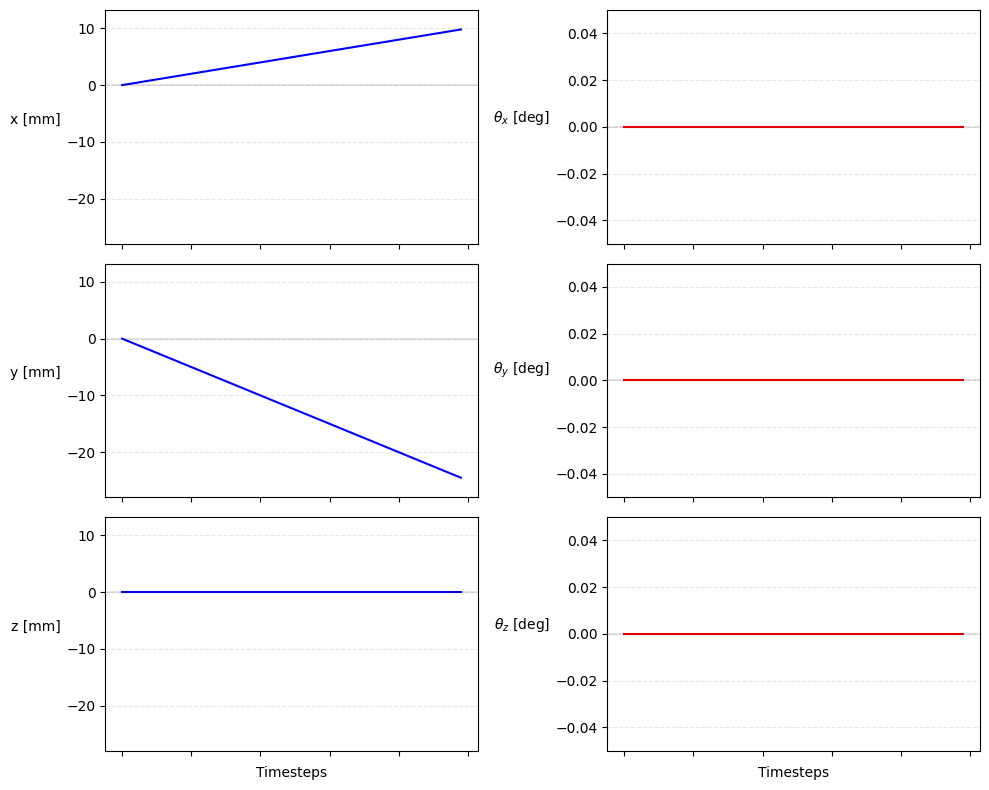

In [8]:
T = 50  # number of discrete time steps to calculate trajectory along
delta_x = [0.01, -0.025, 0.0, 0.0, 0.0, 0.0]  # in meters and degrees
x, q1, q2 = IK.discretize(delta_x, T, polynomial=False)
plot_pose_trajectories(x, T)

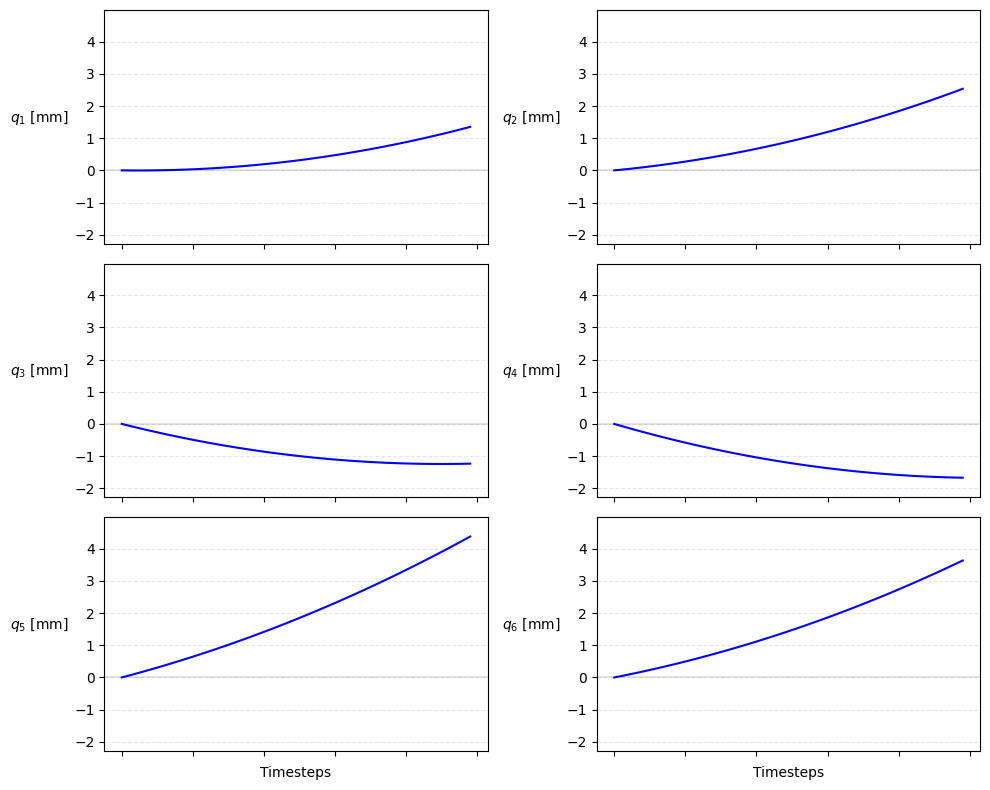

In [9]:
# Take the second solution (platform above the prismatic joints)
q2 = q2.reshape(np.shape(q2)[0], np.shape(q2)[1])
plot_joint_trajectories(q2, T)

## 3. Taking smooth isochronal joint trajectories results in deviations of the end-effector trajectory from a linear trajectory in task space. Here we analyze how large these deviations can get while approaching different goal poses in task space.

Smooth isochronal joint trajectory towards a goal pose

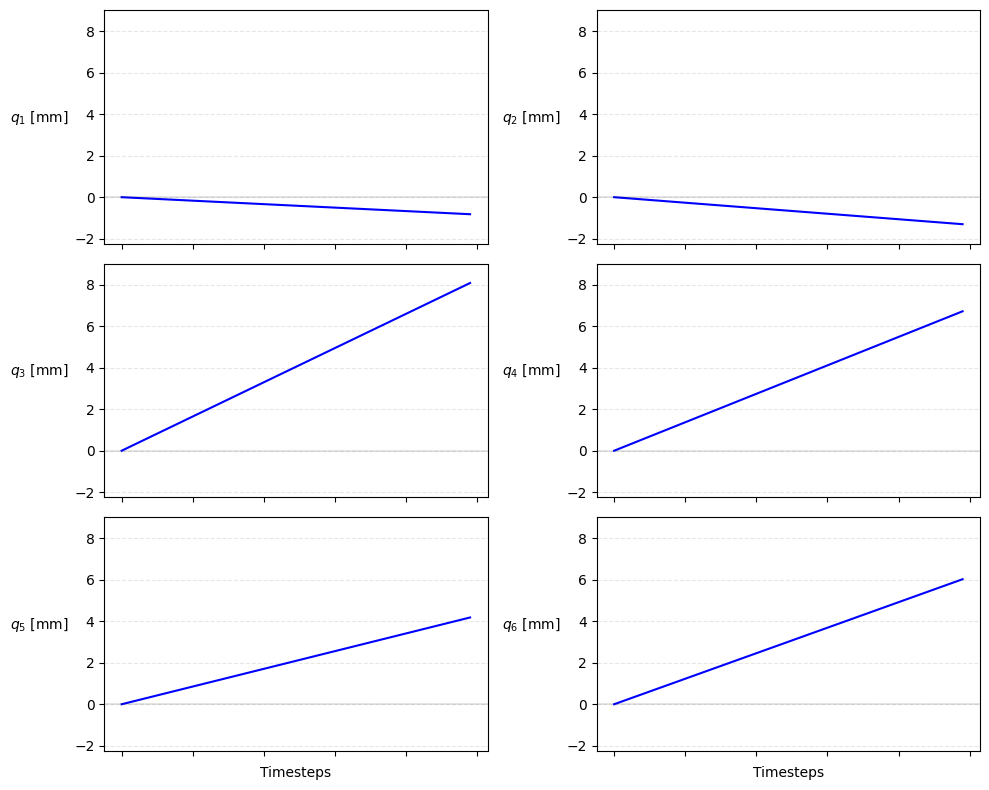

In [10]:
T = 50  # number of discrete time steps to calculate trajectory along

goal_pose = [0.03, 0.03, 0.0, 0.0, 0.0, 0.0]

rx = R.from_euler('x', goal_pose[3], degrees=True)
ry = R.from_euler('y', goal_pose[4], degrees=True)
rz = R.from_euler('z', goal_pose[5], degrees=True)
r = rz * ry * rx
rot = r.as_matrix()
pose_1 = np.array([goal_pose[0], goal_pose[1], goal_pose[2]]).reshape(-1, 1)  # in meters
transform = IK.get_transform_matrix(rot, pose_1)
T_1_0 = IK.transform_1_0(IK.init_T_1_0, transform)
pose_0 = T_1_0[:, -1][:3]
P = IK.init_P_1
q1, q2 = IK.calc_q(pose_0, rot, P)

# Determine the endpoint of joint trajectories
q_e = q2

q_traj = IK.smooth_joint_trajectory(q_e, T, polynomial=False)
#q_traj = IK.equal_velocity_joint_trajectory(q_e, T)

plot_joint_trajectories(q_traj, T)

Resulting pose trajectory

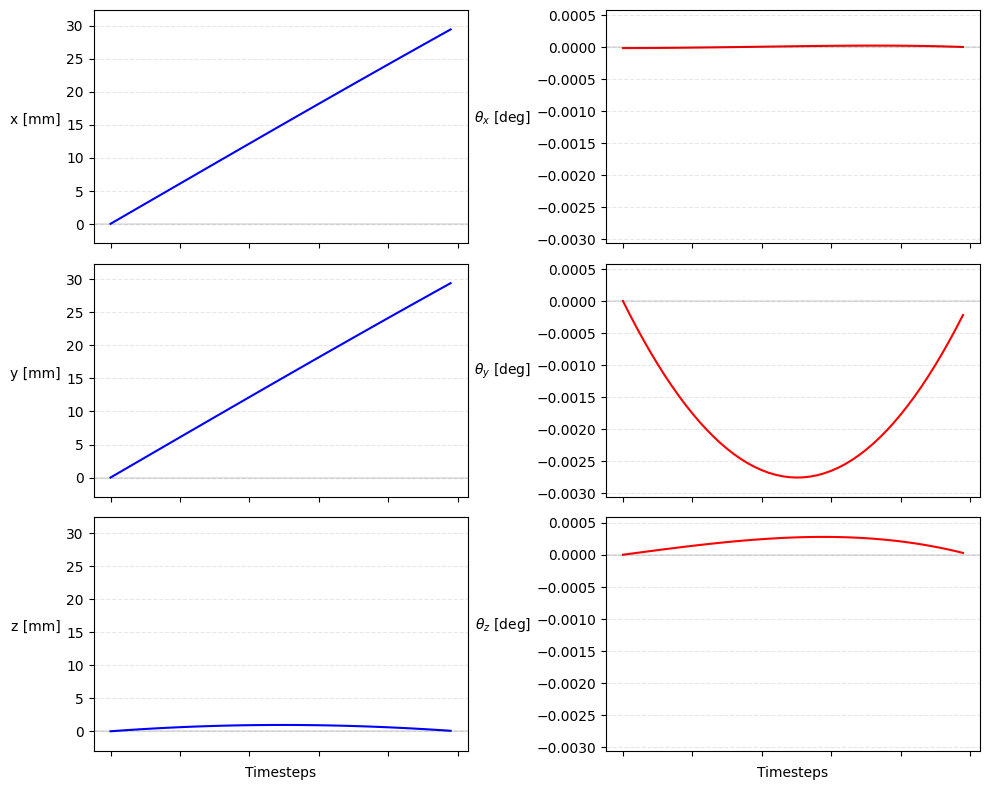

In [11]:
FK = FKSolver()

# Initial (0) pose
rot = np.eye(3, 3)
pose_1 = np.array([0.0, 0.0, 0.0]).reshape(-1, 1)  # input in meters
transform = FK.get_transform_matrix(rot, pose_1)
T_1_0_in = FK.transform_1_0(FK.init_T_1_0, transform)

q_0 = np.zeros(6, dtype=np.float32).reshape(-1, 1)

x_traj = []
z_offset = None

for l in range(T):
    q_l = q_traj[l]
    fk_solution = FK.get_eef_transform_matrix(T_1_0_in, q_0, q_l, n_iter=15, n_q=15)
    x_l = np.zeros(6)
    x_l[:3] = fk_solution[:3,3]
    # record starting height z and subtract it from all values in z series
    if z_offset is None:
        z_offset = x_l[2]
    x_l[2] -= z_offset

    # Also calculate Euler angles back from rotation matrix in FK solution
    theta = R.from_matrix(fk_solution[:3,:3]).as_euler('xyz', degrees=True)
    x_l[3:] = theta

    x_traj.append(x_l)

x_traj = np.array(x_traj)

plot_pose_trajectories(x_traj, T, ignore_rotations=False)

Resulting pose trajectory compared to a linear path (dashed or dotted lines)

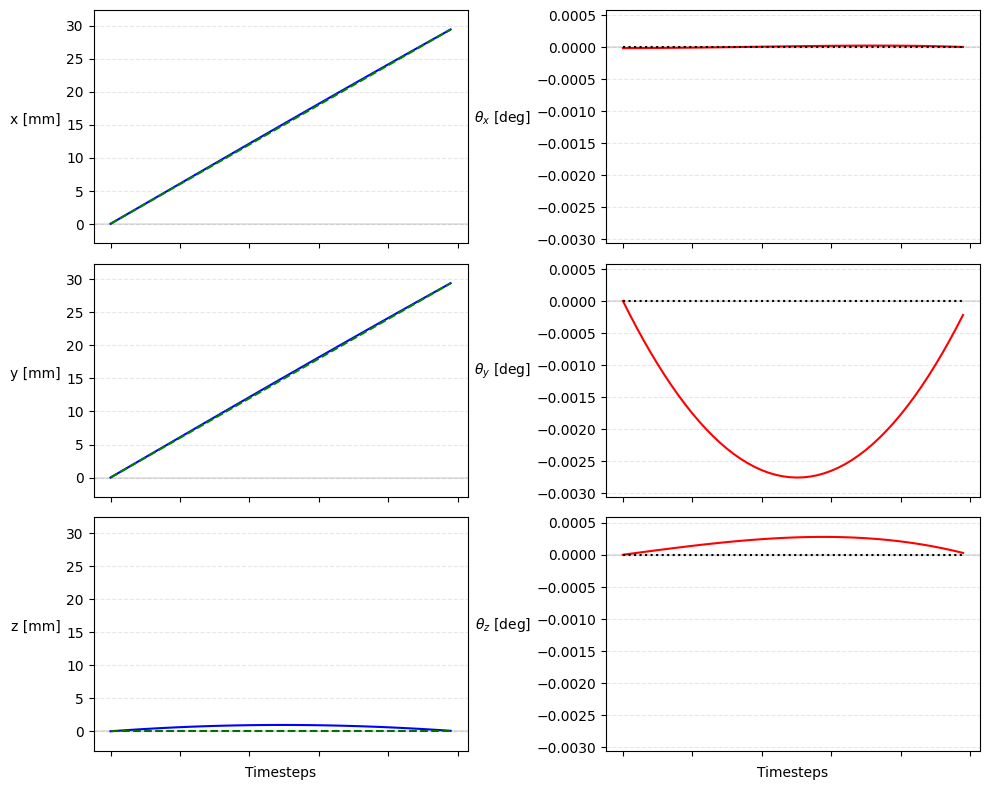

In [12]:
x_lin, q1, q2 = IK.discretize(goal_pose, T, polynomial=False)

plot_pose_trajectory_comparison(x_traj, x_lin, T, save_plot=False, ignore_rotations=False)

3D comparison of position trajectories

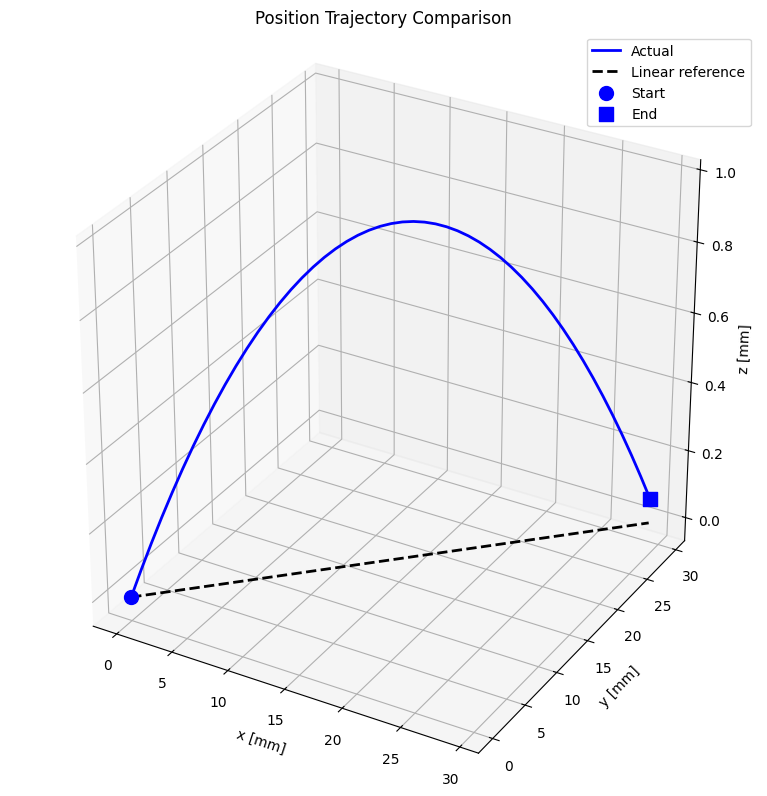

In [13]:
def plot_position_trajectories_3d(x_traj, x_lin, T, save_plot=False):
    """
    Create 3D plot comparing two position trajectories.
    
    Args:
        x_traj: Array of shape (T,6) containing actual trajectory 
        x_lin: Array of shape (T,6) containing linear reference trajectory
        T: Number of timesteps
        save_plot: Whether to save plot to file (default: False)
    """
    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Extract positions (first 3 columns) and convert to mm
    pos_traj = x_traj[:,:3] * 1000
    pos_lin = x_lin[:,:3] * 1000
    
    # Plot trajectories
    ax.plot(pos_traj[:,0], pos_traj[:,1], pos_traj[:,2], 
            'b-', linewidth=2, label='Actual')
    ax.plot(pos_lin[:,0], pos_lin[:,1], pos_lin[:,2],
            'k--', linewidth=2, label='Linear reference')
    
    # Add start/end markers
    ax.scatter(pos_traj[0,0], pos_traj[0,1], pos_traj[0,2], 
              c='blue', marker='o', s=100, label='Start')
    ax.scatter(pos_traj[-1,0], pos_traj[-1,1], pos_traj[-1,2],
              c='blue', marker='s', s=100, label='End')
    
    # Labels and title
    ax.set_xlabel('x [mm]')
    ax.set_ylabel('y [mm]')
    ax.set_zlabel('z [mm]')
    ax.set_title('Position Trajectory Comparison')
    
    # Equal aspect ratio
    ax.set_box_aspect([1,1,1])
    
    # Add legend
    ax.legend()
    
    plt.tight_layout()

plot_position_trajectories_3d(x_traj, x_lin, T)

In [14]:
# Find the largest deviation of the resulting trajectory from the straight line

def find_max_deviation(x_traj, x_lin):
    """
    Find the largest distance between the executed trajectory and the straight line,
    and return the vector components of the maximum deviation point.

    Args:
        x_traj: Array of shape (T,6) containing the executed trajectory (positions and rotations).
        x_lin: Array of shape (T,6) containing the straight-line trajectory (positions and rotations).

    Returns:
        max_distance: The largest distance between x_traj and the straight line.
        max_deviation_vector: The vector components (dx, dy, dz) of the maximum deviation point.
    """
    # Extract positions (first 3 columns) from both trajectories
    # Exclude first and last n points as they tend to have numerical issues
    # if one of the goal position elements is close to 0.0
    pos_traj = x_traj[3:-3, :3]  # x_traj[5:-5, :3]
    start_point = x_lin[0, :3]
    end_point = x_lin[-1, :3]

    # Direction vector of the straight line
    line_vector = end_point - start_point
    line_vector_norm = np.linalg.norm(line_vector)

    # Normalize the line vector
    if all([m.isclose(line_vector[0], 0.0, rel_tol=1e-6),
            m.isclose(line_vector[1], 0.0, rel_tol=1e-6),
            m.isclose(line_vector[2], 0.0, rel_tol=1e-6),]):
        return 0.0, np.array([0.0, 0.0, 0.0])
    
    line_unit_vector = line_vector / line_vector_norm

    max_distance = 0
    max_deviation_vector = np.array([0.0, 0.0, 0.0])

    # Iterate through each point in the executed trajectory
    for point in pos_traj:
        # Vector from the start point to the current point
        point_vector = point - start_point

        # Project the point vector onto the line vector
        projection_length = np.dot(point_vector, line_unit_vector)
        projection_vector = projection_length * line_unit_vector

        # Perpendicular vector from the point to the line
        deviation_vector = point_vector - projection_vector

        # Distance is the magnitude of the deviation vector
        distance = np.linalg.norm(deviation_vector)

        # Update max distance and deviation vector if this is the largest so far
        if distance > max_distance:
            max_distance = distance
            max_deviation_vector = deviation_vector

    return max_distance, max_deviation_vector

max_distance, max_deviation_vector = find_max_deviation(x_traj, x_lin)

print(f"Maximum distance: {max_distance * 1000:.6f} mm")
print(f"Deviation vector (dx, dy, dz) [mm]: {max_deviation_vector * 1000}")

Maximum distance: 0.957874 mm
Deviation vector (dx, dy, dz) [mm]: [-0.01643194  0.01643194  0.95759211]


## Experiment zone

Different goal positions (0 rotations) in the xy-plane: 1 mm raster, +/- 50 mm from the origin (100*100=10000 data points)

Heatmaps show:

1) maximum deviation magnitudes
2) x, y, z components of the maximum deviation vector

In [15]:
def plot_heatmap(data, x_label="x [mm]", y_label="y [mm]", title="Heatmap", cmap="viridis", limit=10):
    """
    Plot a 2D NumPy array as a heatmap.

    Args:
        data: 2D NumPy array to be visualized as a heatmap.
        x_label: Label for the x-axis (default: "x [mm]").
        y_label: Label for the y-axis (default: "y [mm]").
        title: Title of the heatmap (default: "Heatmap").
        cmap: Colormap to use for the heatmap (default: "viridis").
    """
    plt.figure(figsize=(8, 6))
    plt.imshow(data, cmap=cmap, aspect='auto', extent=[-limit-0.5, limit+0.5, -limit-0.5, limit+0.5])
    plt.colorbar(label="Value [mm]")
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.tight_layout()
    plt.show()

In [16]:
step = 1  # mm
limit = 0  # 50 mm used in the paper, set to 0 to skip this calculation

dev_field = np.zeros((2*limit+1, 2*limit+1), dtype=np.float32)
dev_x_field = np.zeros((2*limit+1, 2*limit+1), dtype=np.float32)
dev_y_field = np.zeros((2*limit+1, 2*limit+1), dtype=np.float32)
dev_z_field = np.zeros((2*limit+1, 2*limit+1), dtype=np.float32)

# For matrix indices
i = 0
for x in range(-limit, limit+1, step):  # mm
    j = 0
    for y in range(-limit, limit+1, step):  # mm

        goal_pose = [x / 1000.0, y / 1000.0, 0.0, 0.0, 0.0, 0.0]

        # ---- Calculate smooth isochronal joint trajectories ----
        
        rx = R.from_euler('x', goal_pose[3], degrees=True)
        ry = R.from_euler('y', goal_pose[4], degrees=True)
        rz = R.from_euler('z', goal_pose[5], degrees=True)
        r = rz * ry * rx
        rot = r.as_matrix()
        pose_1 = np.array([goal_pose[0], goal_pose[1], goal_pose[2]]).reshape(-1, 1)  # in meters
        transform = IK.get_transform_matrix(rot, pose_1)
        T_1_0 = IK.transform_1_0(IK.init_T_1_0, transform)
        pose_0 = T_1_0[:, -1][:3]
        P = IK.init_P_1
        q1, q2 = IK.calc_q(pose_0, rot, P)

        # Determine the endpoint of joint trajectories
        q_e = q2

        # ---- Change joint trajectory generation method below ----

        #q_traj = IK.smooth_joint_trajectory(q_e, T, polynomial=False)
        q_traj = IK.equal_velocity_joint_trajectory(q_e, T)

        # ---- Calculate resulting end-effector trajectories ----

        # Initial (0) pose
        rot = np.eye(3, 3)
        pose_1 = np.array([0.0, 0.0, 0.0]).reshape(-1, 1)  # input in meters
        transform = FK.get_transform_matrix(rot, pose_1)
        T_1_0_in = FK.transform_1_0(FK.init_T_1_0, transform)

        q_0 = np.zeros(6, dtype=np.float32).reshape(-1, 1)

        x_traj = []
        z_offset = None

        for l in range(T):
            q_l = q_traj[l]
            fk_solution = FK.get_eef_transform_matrix(T_1_0_in, q_0, q_l, n_iter=15, n_q=15)
            x_l = np.zeros(6)
            x_l[:3] = fk_solution[:3,3]
            # record starting height z and subtract it from all values in z series
            if z_offset is None:
                z_offset = x_l[2]
            x_l[2] -= z_offset

            # Also calculate Euler angles back from rotation matrix in FK solution
            theta = R.from_matrix(fk_solution[:3,:3]).as_euler('xyz', degrees=True)
            x_l[3:] = theta

            x_traj.append(x_l)

        x_traj = np.array(x_traj)

        # ---- Get the linear end-effector path from start to end

        x_lin, _, _ = IK.discretize(goal_pose, T, polynomial=False, skip_ik=True)

        # ---- Get max deviation and its elements for the heatmaps

        max_distance, max_deviation_vector = find_max_deviation(x_traj, x_lin)

        if x == 0 and y == 0:
            max_distance = 0.0
            max_deviation_vector = [0.0, 0.0, 0.0]
            print(max_distance)

        dev_field[i,j] = max_distance * 1000
        dev_x_field[i,j] = max_deviation_vector[0] * 1000
        dev_y_field[i,j] = max_deviation_vector[1] * 1000
        dev_z_field[i,j] = max_deviation_vector[2] * 1000

        j += 1

    i += 1
    print(i)


0.0
1


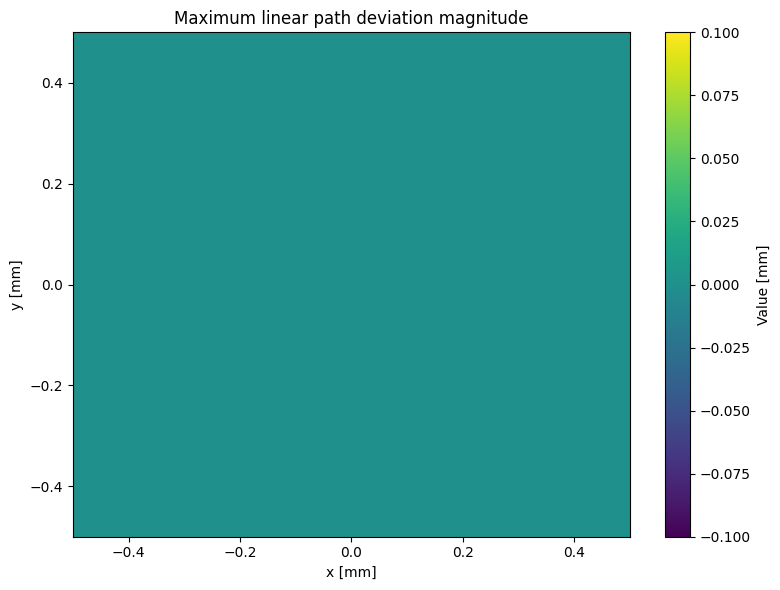

In [17]:
plot_heatmap(dev_field, title='Maximum linear path deviation magnitude', limit=limit)

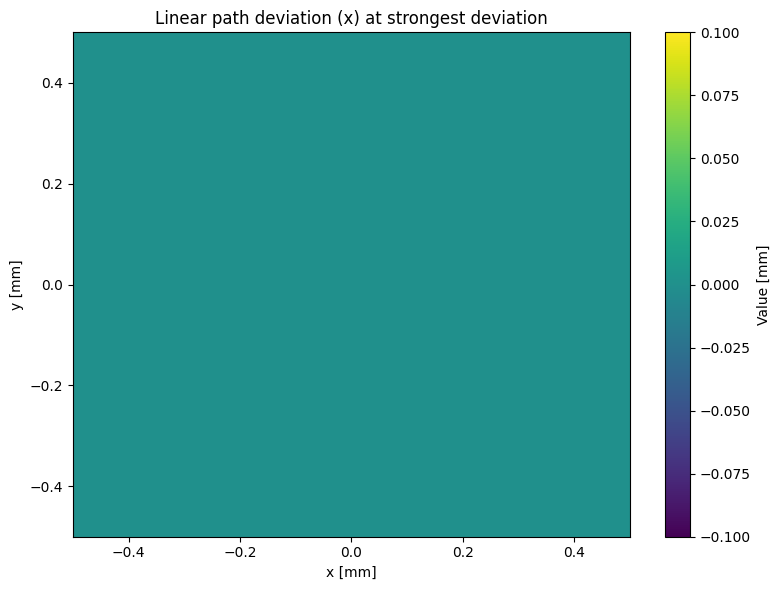

In [18]:
plot_heatmap(dev_x_field, title='Linear path deviation (x) at strongest deviation', limit=limit)

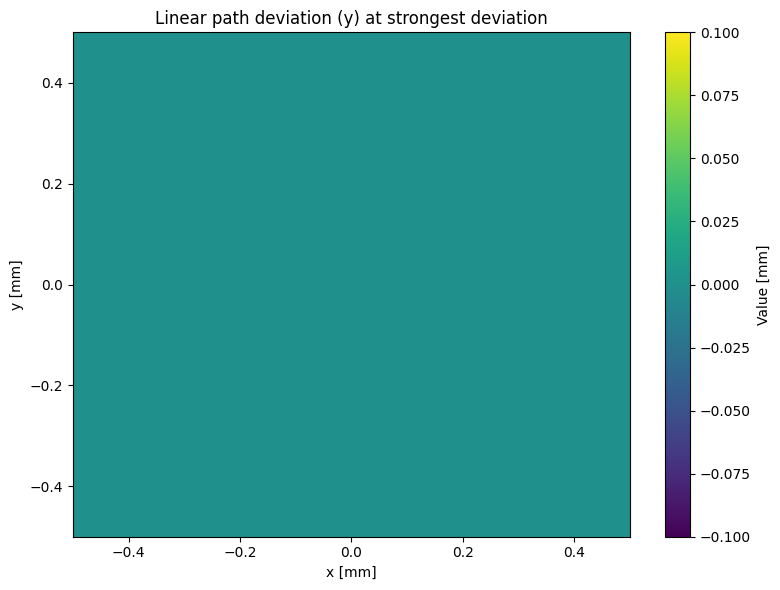

In [19]:
plot_heatmap(dev_y_field, title='Linear path deviation (y) at strongest deviation', limit=limit)

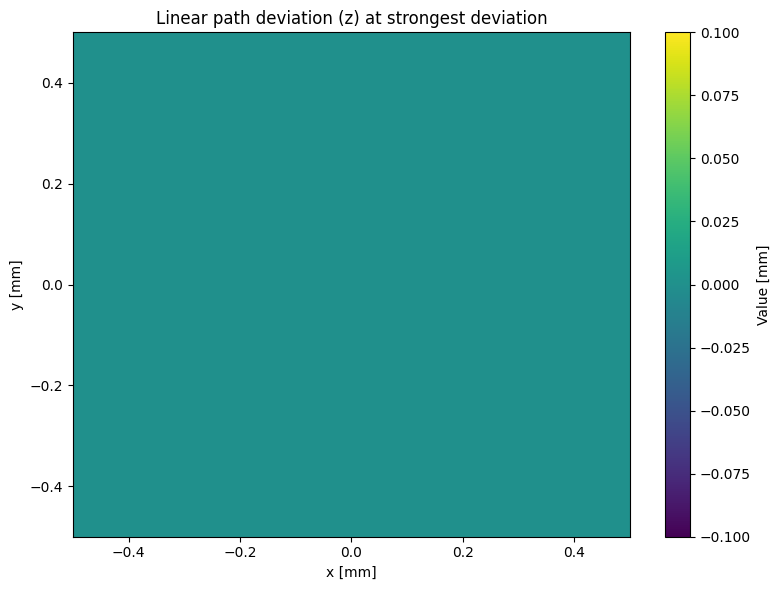

In [20]:
plot_heatmap(dev_z_field, title='Linear path deviation (z) at strongest deviation', limit=limit)

### Linearity deviation analysis along rectangular spiral paths

In [21]:
def plot_position_trajectories_3d_spiral(x_traj, x_lin, T, save_plot=False):
    """
    Create 3D plot comparing two position trajectories.
    
    Args:
        x_traj: Array of shape (T,6) containing actual trajectory 
        x_lin: Array of shape (T,6) containing linear reference trajectory
        T: Number of timesteps
        save_plot: Whether to save plot to file (default: False)
    """
    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Extract positions (first 3 columns) and convert to mm
    pos_traj = x_traj[:,:3] * 1000
    pos_lin = x_lin[:,:3] * 1000
    
    # Plot trajectories
    ax.plot(pos_traj[:,0], pos_traj[:,1], pos_traj[:,2], 
            'b-', linewidth=2, label='Actual')
    ax.plot(pos_lin[:,0], pos_lin[:,1], pos_lin[:,2],
            'k--', linewidth=2, label='Linear reference')
    
    # Add start/end markers
    # ax.scatter(pos_traj[0,0], pos_traj[0,1], pos_traj[0,2], 
    #           c='blue', marker='o', s=100, label='Start')
    # ax.scatter(pos_traj[-1,0], pos_traj[-1,1], pos_traj[-1,2],
    #           c='blue', marker='s', s=100, label='End')
    
    # Labels and title
    ax.set_xlabel('x [mm]')
    ax.set_ylabel('y [mm]')
    ax.set_zlabel('z [mm]')
    ax.set_title('Position Trajectory Comparison')
    
    # Aspect ratio
    ax.set_box_aspect([1,1,1])
    
    # Add legend
    ax.legend()
    
    plt.tight_layout()

curr_pose: [-0.03  0.03  0.    0.    0.   10.  ]
Linearity deviation magnitude: 3.728666594071674e-06
curr_pose: [-0.03008682  0.0304924   0.          0.          0.         10.        ]
Linearity deviation magnitude: 5.485027087002063e-06
curr_pose: [-0.02959442  0.03057923  0.          0.          0.         10.        ]
Linearity deviation magnitude: 3.65174307038696e-06
curr_pose: [-0.0295076   0.03008682  0.          0.          0.         10.        ]
Linearity deviation magnitude: 3.652496745842121e-06
curr_pose: [-0.02942077  0.02959442  0.          0.          0.         10.        ]
Linearity deviation magnitude: 5.329123709293726e-06
curr_pose: [-0.02991318  0.0295076   0.          0.          0.         10.        ]
Linearity deviation magnitude: 5.32887987324035e-06
curr_pose: [-0.03040558  0.02942077  0.          0.          0.         10.        ]
Linearity deviation magnitude: 3.806785758852477e-06
curr_pose: [-0.0304924   0.02991318  0.          0.          0.         

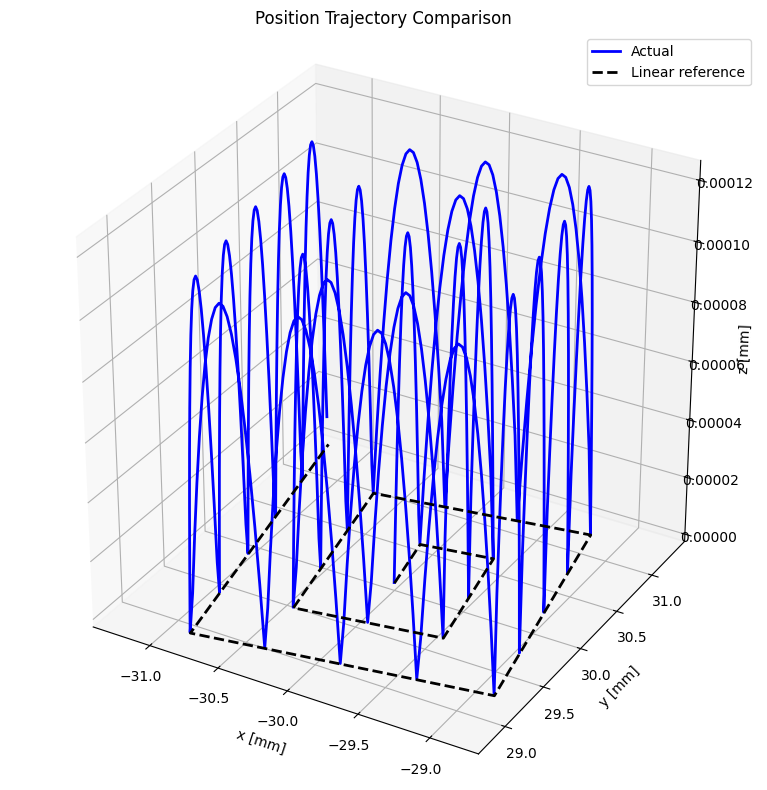

In [50]:
import copy

# === Spiral Configuration ===
b = 0.5 / 1000         # Step size in meters
r_max = 1.2 / 1000     # Max radius in meters, set to 0 to skip calculation
T = 20                 # Steps per segment

rot_dir = 'CW'         # 'CW' or 'CCW'
start_dir = 'N'        # 'N', 'E', 'S', 'W'

# Direction settings
rot_dirs = {'CW': 1, 'CCW': -1}
dirs = {
    'N': np.array([0.0, 1.0, 0.0, 0.0, 0.0, 0.0]),
    'E': np.array([1.0, 0.0, 0.0, 0.0, 0.0, 0.0]),
    'S': np.array([0.0, -1.0, 0.0, 0.0, 0.0, 0.0]),
    'W': np.array([-1.0, 0.0, 0.0, 0.0, 0.0, 0.0])
}

# Build direction sequence
base_seq = ['N', 'E', 'S', 'W']
rot_sign = rot_dirs[rot_dir]
spiral_seq = base_seq[::rot_sign]

# Rotate sequence to start with start_dir
start_idx = spiral_seq.index(start_dir)
spiral_seq = spiral_seq[start_idx:] + spiral_seq[:start_idx]

# Initial pose
start_pose = np.array([-0.03, 0.03, 0.0, 0.0, 0.0, 10.0], dtype=np.float32)
goal_pose = start_pose.copy()
curr_pose = start_pose.copy()

# Apply theta_z rotation if non-zero
if start_pose[5] != 0.0:
    theta_z_rad = start_pose[5] * m.pi / 180.0
    dirs = {
        'N': np.array([-m.sin(theta_z_rad), m.cos(theta_z_rad), 0.0, 0.0, 0.0, 0.0]),
        'E': np.array([m.cos(theta_z_rad), m.sin(theta_z_rad), 0.0, 0.0, 0.0, 0.0]),
        'S': np.array([m.sin(theta_z_rad), -m.cos(theta_z_rad), 0.0, 0.0, 0.0, 0.0]),
        'W': np.array([-m.cos(theta_z_rad), -m.sin(theta_z_rad), 0.0, 0.0, 0.0, 0.0])
    }

# State vars
curr_dir_idx = 0
arm_length = 1
steps_in_dir = 0
steps_before_turn = 1

x_lin_spiral = []
x_traj_spiral = []

max_dev_mag = 0.0
max_dev_vec = None

# === Main Spiral Loop ===
while np.max(np.abs(goal_pose[:2] - start_pose[:2])) <= r_max:

    print('curr_pose:', curr_pose)
    dir_vec = dirs[spiral_seq[curr_dir_idx % 4]]
    goal_pose += dir_vec * b
    #print('goal_pose:', goal_pose)
    steps_in_dir += 1

    if steps_in_dir == steps_before_turn:
        curr_dir_idx += 1
        steps_in_dir = 0
        if curr_dir_idx % 2 == 0:
            steps_before_turn += 1

    # --- Inverse Kinematics ---

    # End joint config
    rx = R.from_euler('x', goal_pose[3], degrees=True)
    ry = R.from_euler('y', goal_pose[4], degrees=True)
    rz = R.from_euler('z', goal_pose[5], degrees=True)
    rot = (rz * ry * rx).as_matrix()
    pos = goal_pose[:3].reshape(3, 1)
    transform = IK.get_transform_matrix(rot, pos)
    T_1_0 = IK.transform_1_0(IK.init_T_1_0, transform)
    goal_pos_0 = T_1_0[:3, -1]
    q1, q2 = IK.calc_q(goal_pos_0, rot, IK.init_P_1)
    q_e = q2

    # Start joint config
    rx = R.from_euler('x', curr_pose[3], degrees=True)
    ry = R.from_euler('y', curr_pose[4], degrees=True)
    rz = R.from_euler('z', curr_pose[5], degrees=True)
    rot = (rz * ry * rx).as_matrix()
    pos = curr_pose[:3].reshape(3, 1)
    transform = IK.get_transform_matrix(rot, pos)
    T_1_0 = IK.transform_1_0(IK.init_T_1_0, transform)
    curr_pos_0 = T_1_0[:3, -1]
    _, q_start = IK.calc_q(curr_pos_0, rot, IK.init_P_1)

    q_traj = IK.smooth_joint_trajectory_nonzero_start(q_start, q_e, T, polynomial=False)

    # --- Forward Kinematics ---
    T_1_0_in = FK.transform_1_0(FK.init_T_1_0, FK.get_transform_matrix(np.eye(3), np.zeros((3,1))))
    q_0 = np.zeros((6, 1), dtype=np.float32)
    x_traj = []
    z_offset = None

    for q_l in q_traj:
        fk = FK.get_eef_transform_matrix(T_1_0_in, q_0, q_l, n_iter=50, n_q=50)
        x_l = np.zeros(6)
        x_l[:3] = fk[:3, 3]
        if z_offset is None:
            z_offset = x_l[2]
        x_l[2] -= z_offset
        x_l[3:] = R.from_matrix(fk[:3, :3]).as_euler('xyz', degrees=True)
        x_traj.append(x_l)

    #print('Appending x_traj:', x_traj)
    x_traj_spiral.append(np.array(x_traj))

    # --- Linear interpolation in pose space ---
    x_delta, _, _ = IK.discretize(goal_pose - curr_pose, T, polynomial=True, skip_ik=True)
    x_interp = curr_pose + x_delta
    #print('Appending x_interp:', x_interp)
    x_lin_spiral.append(x_interp)

    # Check for maximum deviation
    temp_max_dev_mag, temp_max_dev_vec = find_max_deviation(np.array(x_traj), x_interp)
    print('Linearity deviation magnitude:', temp_max_dev_mag)
    if temp_max_dev_mag > max_dev_mag:
        max_dev_mag = temp_max_dev_mag
        max_dev_vec = temp_max_dev_vec

    curr_pose = goal_pose.copy()

# === Final Outputs ===
x_lin_spiral = np.vstack(x_lin_spiral)
x_traj_spiral = np.vstack(x_traj_spiral)

plot_position_trajectories_3d_spiral(x_traj_spiral, x_lin_spiral, T)

Check whether the joint configuration for the highest deviation (x_m) is indeed the middle between q_start and q_end (how accurate or reliable are these tiny z deviations that we are seeing?)

In [51]:
# start_pose is the center of the spiral and has been already input
end_pose = start_pose + b * dirs[start_dir]
print('start_pose:', start_pose)
print('end_pose:', end_pose)

# Start joint config
rx = R.from_euler('x', start_pose[3], degrees=True)
ry = R.from_euler('y', start_pose[4], degrees=True)
rz = R.from_euler('z', start_pose[5], degrees=True)
rot = (rz * ry * rx).as_matrix()
pos = start_pose[:3].reshape(3, 1)
transform = IK.get_transform_matrix(rot, pos)
T_1_0 = IK.transform_1_0(IK.init_T_1_0, transform)
start_pos_0 = T_1_0[:3, -1]
_, q_start = IK.calc_q(start_pos_0, rot, IK.init_P_1)
print('q_start:', q_start)

# End joint config
rx = R.from_euler('x', end_pose[3], degrees=True)
ry = R.from_euler('y', end_pose[4], degrees=True)
rz = R.from_euler('z', end_pose[5], degrees=True)
rot = (rz * ry * rx).as_matrix()
pos = end_pose[:3].reshape(3, 1)
transform = IK.get_transform_matrix(rot, pos)
T_1_0 = IK.transform_1_0(IK.init_T_1_0, transform)
end_pos_0 = T_1_0[:3, -1]
_, q_end = IK.calc_q(end_pos_0, rot, IK.init_P_1)
print('q_end:', q_end)

# --- Forward Kinematics for the middle point (tends to be the one with the strongest devition) ---
T_1_0_in = FK.transform_1_0(FK.init_T_1_0, FK.get_transform_matrix(np.eye(3), np.zeros((3,1))))
q_0 = np.zeros((6, 1), dtype=np.float32)

q_mid = (q_end + q_start) / 2
print('q_mid:', q_mid)

# Get z_offset from the first point (must be z=0)
fk = FK.get_eef_transform_matrix(T_1_0_in, q_0, q_start, n_iter=50, n_q=50)
x_start = np.zeros(6)
x_start[:3] = fk[:3, 3]
z_offset = x_start[2]

# Get x_mid at q_mid
fk = FK.get_eef_transform_matrix(T_1_0_in, q_0, q_mid, n_iter=50, n_q=50)
x_mid = np.zeros(6)
x_mid[:3] = fk[:3, 3]
x_mid[2] -= z_offset
x_mid[3:] = R.from_matrix(fk[:3, :3]).as_euler('xyz', degrees=True)
print('x_mid:', x_mid)

# Get q_mid from x_mid again
rx = R.from_euler('x', x_mid[3], degrees=True)
ry = R.from_euler('y', x_mid[4], degrees=True)
rz = R.from_euler('z', x_mid[5], degrees=True)
rot = (rz * ry * rx).as_matrix()
pos = x_mid[:3].reshape(3, 1)
transform = IK.get_transform_matrix(rot, pos)
T_1_0 = IK.transform_1_0(IK.init_T_1_0, transform)
x_mid_pos_0 = T_1_0[:3, -1]
_, q_mid_from_ik = IK.calc_q(x_mid_pos_0, rot, IK.init_P_1)
print('q_mid_from_ik:', q_mid_from_ik)

q_diff = q_mid_from_ik - q_mid
print('q_diff:', q_diff)


start_pose: [-0.03  0.03  0.    0.    0.   10.  ]
end_pose: [-0.03008682  0.0304924   0.          0.          0.         10.        ]
q_start: [[ 0.01120883]
 [ 0.00484139]
 [ 0.00986243]
 [ 0.0040307 ]
 [-0.00170101]
 [-0.00045309]]
q_end: [[ 0.01128766]
 [ 0.00491964]
 [ 0.01002569]
 [ 0.00413938]
 [-0.00170869]
 [-0.00041291]]
q_mid: [[ 0.01124825]
 [ 0.00488052]
 [ 0.00994406]
 [ 0.00408504]
 [-0.00170485]
 [-0.000433  ]]
x_mid: [-3.00480335e-02  3.02509521e-02  1.11599141e-07 -1.64289373e-04
  2.42239619e-04  1.00016042e+01]
q_mid_from_ik: [[ 0.01125078]
 [ 0.00488198]
 [ 0.00994637]
 [ 0.00408637]
 [-0.00170441]
 [-0.00043238]]
q_diff: [[2.53020917e-06]
 [1.46227106e-06]
 [2.30475327e-06]
 [1.33271446e-06]
 [4.39630111e-07]
 [6.24459033e-07]]


Get some stats on the biggest deviations along the spiral path

In [52]:
print('Maximum deviation magnitude:', max_dev_mag)
print('Maximum deviation vector:', max_dev_vec)

Maximum deviation magnitude: 5.563158061278764e-06
Maximum deviation vector: [-9.65828668e-07  5.47736270e-06  1.20002050e-07]


Calculate sensitivity and isotropy using a numeric Jacobian

In [ ]:
def numeric_jacobian(q0, dq=1e-4):
    n_q = len(q0)
    T_1_0_in = FK.transform_1_0(FK.init_T_1_0, FK.get_transform_matrix(np.eye(3), np.zeros((3,1))))
    T0 = FK.get_eef_transform_matrix(T_1_0_in, q0, q0, n_iter=50, n_q=50)
    pos0 = T0[:3, 3]

    J_numeric = np.zeros((3, n_q))
    for i in range(n_q):
        dq_vec = np.zeros_like(q0)
        dq_vec[i] = dq
        T1 = FK.get_eef_transform_matrix(FK.init_T_1_0, q0, q0 + dq_vec, n_iter=50, n_q=50)
        pos1 = T1[:3, 3]
        J_numeric[:, i] = (pos1 - pos0) / dq
    return J_numeric

test_pose = np.array([0.022, 0.0, 0.0, 0.0, 0.0, 0.0])

rx = R.from_euler('x', test_pose[3], degrees=True)
ry = R.from_euler('y', test_pose[4], degrees=True)
rz = R.from_euler('z', test_pose[5], degrees=True)
r = rz * ry * rx
rot = r.as_matrix()
pose_1 = np.array([test_pose[0], test_pose[1], test_pose[2]]).reshape(-1, 1)  # in meters
transform = IK.get_transform_matrix(rot, pose_1)
T_1_0 = IK.transform_1_0(IK.init_T_1_0, transform)
pose_0 = T_1_0[:, -1][:3]
P = IK.init_P_1
_, test_joints = IK.calc_q(pose_0, rot, P)

J_loc = numeric_jacobian(test_joints)

print(J_loc)

In [ ]:
frobenius = np.linalg.norm(J_loc, 'fro')
spectral = np.linalg.norm(J_loc, 2)
row_max = np.max(np.abs(J_loc), axis=1)
condition = np.linalg.cond(J_loc)

U, S, Vt = np.linalg.svd(J_loc)
manipulability = np.prod(S)  # For square or reduced J

print(frobenius)
print(spectral)
print(row_max)
print(condition)
print(manipulability)

### Nonlinearity analysis using second derivative of local FK

The second derivative provides information on linearity of transmission from q to x. It makes sense to first find such areas in the workspace where the second derivative is large and then specifically examine that areas with the spirals and see whether linearity deviations are significant there.

In [ ]:
def numeric_jacobian_2(q0, dq=1e-4):
    n_q = len(q0)
    T_1_0_in = FK.transform_1_0(FK.init_T_1_0, FK.get_transform_matrix(np.eye(3), np.zeros((3,1))))
    T0 = FK.get_eef_transform_matrix(T_1_0_in, q0, q0, n_iter=50, n_q=50)
    pos0 = T0[:3, 3]

    J_numeric = np.zeros((3, n_q))
    for i in range(n_q):
        dq_vec = np.zeros_like(q0)
        dq_vec[i] = dq
        # T1 is for minus, T2 is for plus
        T1 = FK.get_eef_transform_matrix(FK.init_T_1_0, q0, q0 - dq_vec, n_iter=50, n_q=50)
        pos1 = T1[:3, 3]
        T2 = FK.get_eef_transform_matrix(FK.init_T_1_0, q0, q0 + dq_vec, n_iter=50, n_q=50)
        pos2 = T2[:3, 3]
        J_numeric[:, i] = abs((pos2 - 2 * pos0 + pos1) / (dq * dq))
    return J_numeric

# Attention: q is input, not EEF pose!
#test_pose = np.array([0.01, 0.01, 0.0, 0.0, 0.0, -10.0])

rx = R.from_euler('x', test_pose[3], degrees=True)
ry = R.from_euler('y', test_pose[4], degrees=True)
rz = R.from_euler('z', test_pose[5], degrees=True)
r = rz * ry * rx
rot = r.as_matrix()
pose_1 = np.array([test_pose[0], test_pose[1], test_pose[2]]).reshape(-1, 1)  # in meters
transform = IK.get_transform_matrix(rot, pose_1)
T_1_0 = IK.transform_1_0(IK.init_T_1_0, transform)
pose_0 = T_1_0[:, -1][:3]
P = IK.init_P_1
_, test_joints = IK.calc_q(pose_0, rot, P)

J_loc_2 = numeric_jacobian_2(test_joints)

print(J_loc_2)

In [ ]:
row_max_2 = np.max(J_loc_2, axis=1)
print(row_max_2)

In [ ]:
step = 1  # mm
limit = 0  # 30 mm used in the paper, set to 0 to skip this calculation

der2_x_field = np.zeros((2*limit+1, 2*limit+1), dtype=np.float32)
der2_y_field = np.zeros((2*limit+1, 2*limit+1), dtype=np.float32)
der2_z_field = np.zeros((2*limit+1, 2*limit+1), dtype=np.float32)

# For matrix indices
i = 0
for x in range(-limit, limit+1, step):  # mm
    j = 0
    for y in range(-limit, limit+1, step):  # mm

        goal_pose = [x / 1000.0, y / 1000.0, 0.0, 0.0, 0.0, 10.0]  # change z rotations here
        print('Test pose:\t', goal_pose)

        # ---- Calculate row maxima of second derivative matrix ----
        
        rx = R.from_euler('x', goal_pose[3], degrees=True)
        ry = R.from_euler('y', goal_pose[4], degrees=True)
        rz = R.from_euler('z', goal_pose[5], degrees=True)
        r = rz * ry * rx
        rot = r.as_matrix()
        #rot = np.eye(3)
        pose_1 = np.array([goal_pose[0], goal_pose[1], goal_pose[2]]).reshape(-1, 1)  # in meters
        transform = IK.get_transform_matrix(rot, pose_1)
        T_1_0 = IK.transform_1_0(IK.init_T_1_0, transform)
        pose_0 = T_1_0[:, -1][:3]
        P = IK.init_P_1

        _, test_joints = IK.calc_q(pose_0, rot, P)

        J_loc_2 = numeric_jacobian_2(test_joints)
        row_max_2 = np.max(J_loc_2, axis=1)
        print('row_max_2:\t', row_max_2)
        print('\n')

        der2_x_field[i,j] = row_max_2[0]
        der2_y_field[i,j] = row_max_2[1]
        der2_z_field[i,j] = row_max_2[2]

        j += 1

    i += 1
    print('i =', i)

In [ ]:
plot_heatmap(der2_x_field, title='Maximum 2nd derivative in x of x(q) w.r.t. q', limit=limit)

In [ ]:
plot_heatmap(der2_y_field, title='Maximum 2nd derivative in y of x(q) w.r.t. q', limit=limit)

In [ ]:
plot_heatmap(der2_z_field, title='Maximum 2nd derivative in z of x(q) w.r.t. q', limit=limit)

### Bar length error sensitivity (random sampling)

In [ ]:
step = 5  # mm
limit = 30  # 30 mm used in the paper, set to 0 to skip this calculation

# Bar length sensitivity field (6 values per test position)
L_sens_field = np.zeros((2*limit//step+1, 2*limit//step+1, 6), dtype=np.float32)

# L taken from IK init
L_array_0 = IK.L
L0 = IK.L[0][0]  # m

# Max. component-wise error
dL = 0.1 / 1000  # m

# For matrix indices
i = 0
for x in range(-limit, limit+1, step):  # mm
    j = 0
    for y in range(-limit, limit+1, step):  # mm
        print(f'\nTest position: ({x}, {y}, 0) mm')

        test_pose = [x / 1000.0, y / 1000.0, 0.0, 0.0, 0.0, 10.0]  # change z rotations here
        print('Test pose:\t', test_pose)

        # Make sure to overwrite any changes to IK config from other iterations
        IK.L = L_array_0

        # Get joint positions using IK (fixed during sampling)
        rx = R.from_euler('x', test_pose[3], degrees=True)
        ry = R.from_euler('y', test_pose[4], degrees=True)
        rz = R.from_euler('z', test_pose[5], degrees=True)
        r = rz * ry * rx
        rot = r.as_matrix()
        #rot = np.eye(3)
        pose_1 = np.array([test_pose[0], test_pose[1], test_pose[2]]).reshape(-1, 1)  # in meters
        transform = IK.get_transform_matrix(rot, pose_1)
        T_1_0 = IK.transform_1_0(IK.init_T_1_0, transform)
        pose_0 = T_1_0[:, -1][:3]
        P = IK.init_P_1

        _, test_joints = IK.calc_q(pose_0, rot, P)

        T_1_0_in = FK.transform_1_0(FK.init_T_1_0, FK.get_transform_matrix(np.eye(3), np.zeros((3,1))))
        q_0 = np.zeros((6, 1), dtype=np.float32)

        z_offset = None

        # Helper variables for max. dev calculation
        max_pose_error = np.zeros(6)

        for n in range(10):  # 10 random error arrays
            L_sample = np.random.uniform(low=L0-dL, high=L0+dL, size=(6,1))
            print(f'L_sample: {L_sample*1000} mm')

            # Set new varied bar lengths as IK attribute
            IK.L = L_sample

            # Get resulting EEF pose using FK
            fk = FK.get_eef_transform_matrix(T_1_0_in, q_0, test_joints, n_iter=50, n_q=50)
            x_test = np.zeros(6)
            x_test[:3] = fk[:3, 3]
            if z_offset is None:
                z_offset = x_test[2]
            x_test[2] -= z_offset
            x_test[3:] = R.from_matrix(fk[:3, :3]).as_euler('xyz', degrees=True)
            
            # Get deviation vector
            x_err = x_test - np.array(test_pose)

            # See whether some absolute value of the pose error is larger than so far recorded at this test pose
            for k in range(6):
                if np.abs(x_err[k]) > max_pose_error[k]:
                    max_pose_error[k] = np.abs(x_err[k])

        j += 1

        print(f'max_pose_error: {max_pose_error}')

        L_sens_field[j,i,:] = max_pose_error * 1000  # mm for better understanding

    i += 1


In [ ]:
plot_heatmap(L_sens_field[:,:,0], title='Maximum position deviation in x', limit=limit)